# Assignment 3: Logistic Regression and SVMs


<mark> Ethan Wen - 2/20/2022 - Professor Mishra </mark>

From Kaggle, we will be using data about Mount Rainier Weather and Climbing. The assingment asks us to develop a mobile application to determine whether one should climb Mount Rainier based on a set of features. 

We can find the dataset located here: [Click Here](https://www.kaggle.com/datasets/codersree/mount-rainier-weather-and-climbing-data?select=Rainier_Weather.csv)

The features are: Battery Voltage AVG, Temperature AVG, Relative Humidity AVG, Wind Speed Daily AVG, Wind Direction AVG, Solar Radiation AVG, and Route (although it's included in the other sheet). 

The outputs that we are trying to predict would be the column called **'Succeeded'**. 

Our output would be determined as either **0 or 1** which would stand for **don't hike and hike** Mt. Rainer respectively. 

## 1. Feature Engineering 

In [2]:
import pandas as pd
mtrainier_df = pd.read_csv("MtRainier_data.csv")
print (f"Shape of data {mtrainier_df.shape}")



Shape of data (1895, 10)


As we can see here, the original dataset holds **10** columns and contains **1895** rows. The following code will try to find duplicates and drop columns that have missing data in one of their columns to make a better model. 

In [3]:
mtrainier_df = mtrainier_df.drop_duplicates()

mtrainier_df = mtrainier_df.dropna()
print (f"Shape of data {mtrainier_df.shape}")
mtrainier_df.head()

Shape of data (1895, 10)


,Unnamed: 0,Date,Route,Succeeded,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,0,11/27/2015,Disappointment Cleaver,0,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,1,11/21/2015,Disappointment Cleaver,0,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,2,10/15/2015,Disappointment Cleaver,0,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,3,10/13/2015,Little Tahoma,0,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,4,10/9/2015,Disappointment Cleaver,0,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292


It seems like we have the same amount of rows so all of these data entries seem to be non-duplicates and aren't missing any data. However, there is an 'Unnamed' Section that replicates our index. 

In [4]:
mtrainier_df.columns

Index(['Unnamed: 0', 'Date', 'Route', 'Succeeded', 'Battery Voltage AVG',
       'Temperature AVG', 'Relative Humidity AVG', 'Wind Speed Daily AVG',
       'Wind Direction AVG', 'Solare Radiation AVG'],
      dtype='object')

In [5]:
mtrainier_df.pop("Unnamed: 0")
mtrainier_df.head()

0          0
1          1
2          2
3          3
4          4
        ... 
1890    1890
1891    1891
1892    1892
1893    1893
1894    1894
Name: Unnamed: 0, Length: 1895, dtype: int64

,Date,Route,Succeeded,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,11/27/2015,Disappointment Cleaver,0,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,11/21/2015,Disappointment Cleaver,0,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,10/15/2015,Disappointment Cleaver,0,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,10/13/2015,Little Tahoma,0,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,10/9/2015,Disappointment Cleaver,0,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292


One thing that I am confused about is the use of date as a feature or if its just useless. The other features seem to be more related to the prediction of a trip to Mt. Rainier being successful. For now, I will probably just use date as an index instead since we don't need it. 

Most of our features seem to be numerical: Battery Voltage AVG, Temperature AVG, Relative Humidity AVG, Wind Speed Daily AVG, Wind Direction AVG,and Solare Radiation AVG. However, Route and Succeeded are both categorical data. 'Route' is a **categorical nominal variable** since its talking about different summit routes while 'Succeeded' could be a **categorical nominal binary variable** since its talking about two different outcomes - not hiking and hiking - which are related to each other in order. 

In [6]:
mtrainier_labels_df = pd.DataFrame(mtrainier_df[["Succeeded"]])
mtrainier_df.pop("Succeeded")
mtrainier_dates_df = pd.DataFrame(mtrainier_df.pop("Date")) #I don't think we need it but I'll save it. 
mtrainier_features_df = mtrainier_df
mtrainier_features_df.head()

0       0
1       0
2       0
3       0
4       0
       ..
1890    0
1891    1
1892    1
1893    0
1894    0
Name: Succeeded, Length: 1895, dtype: int64

,Route,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,Disappointment Cleaver,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,Disappointment Cleaver,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,Disappointment Cleaver,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,Little Tahoma,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,Disappointment Cleaver,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292


Before scaling, we need to deal with the **categorical nominal variable - Route**. Since its a categorical nominal variable, I will use one-hot encoding. 

In [7]:
route_list = mtrainier_features_df["Route"].to_list()
print(route_list[:5])

['Disappointment Cleaver', 'Disappointment Cleaver', 'Disappointment Cleaver', 'Little Tahoma', 'Disappointment Cleaver']


In [8]:
set(route_list)

{'Curtis RIngraham Directge',
 'Disappointment Cleaver',
 'Emmons-Winthrop',
 "Fuhrer's Finger",
 'Fuhrers Finger',
 'Gibralter Chute',
 'Gibralter Ledges',
 'Ingraham Direct',
 'Kautz Cleaver',
 'Kautz Glacier',
 'Liberty RIngraham Directge',
 'Little Tahoma',
 'Mowich Face',
 'Nisqually Glacier',
 'Ptarmigan RIngraham Directge',
 'Success Cleaver',
 'Sunset RIngraham Directge',
 'Tahoma Cleaver',
 'Tahoma Glacier',
 'Unknown',
 'Wilson Headwall',
 'glacier only - no summit attempt'}

In [9]:
route_list_of_lists = []

for i in route_list: 
    route_list_of_lists.append([i])

print(route_list_of_lists[:5])

[['Disappointment Cleaver'], ['Disappointment Cleaver'], ['Disappointment Cleaver'], ['Little Tahoma'], ['Disappointment Cleaver']]


In [10]:
from sklearn.preprocessing import OneHotEncoder

route_encoder = OneHotEncoder()

route_encoder.fit(route_list_of_lists)

print(f"Unique vocabulary items {len(route_encoder.categories_[0])}\n")

route_transformed = route_encoder.transform(route_list_of_lists)

route_transformed = route_transformed.toarray()

print(route_transformed)

OneHotEncoder()

Unique vocabulary items 22

[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [11]:
type(route_transformed)

numpy.ndarray

In [12]:
route_transformed_df = pd.DataFrame(route_transformed)

Instead of replacing the labels one by one, I will use the method that I implemented in Assignment 2 to replace the column names.

In [13]:
temp_list = []
for i in range(len(route_transformed_df.columns)):
    temp = list(route_transformed_df[i])
    temp_list.append(temp.index(1.0))

In [14]:
route_name_list = []
for i in temp_list:
    route_name_list.append(mtrainier_features_df["Route"][i])
print(route_name_list)

['Curtis RIngraham Directge', 'Disappointment Cleaver', 'Emmons-Winthrop', "Fuhrer's Finger", 'Fuhrers Finger', 'Gibralter Chute', 'Gibralter Ledges', 'Ingraham Direct', 'Kautz Cleaver', 'Kautz Glacier', 'Liberty RIngraham Directge', 'Little Tahoma', 'Mowich Face', 'Nisqually Glacier', 'Ptarmigan RIngraham Directge', 'Success Cleaver', 'Sunset RIngraham Directge', 'Tahoma Cleaver', 'Tahoma Glacier', 'Unknown', 'Wilson Headwall', 'glacier only - no summit attempt']


In [15]:
route_transformed_df.columns = route_name_list

In [16]:
route_transformed_df.head()

,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,Fuhrers Finger,Gibralter Chute,Gibralter Ledges,Ingraham Direct,Kautz Cleaver,Kautz Glacier,...,Mowich Face,Nisqually Glacier,Ptarmigan RIngraham Directge,Success Cleaver,Sunset RIngraham Directge,Tahoma Cleaver,Tahoma Glacier,Unknown,Wilson Headwall,glacier only - no summit attempt
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We have replaced all of the number columns with the actual route names. 

In [17]:
print(route_transformed_df.shape)
print(mtrainier_features_df.shape)

(1895, 22)
(1895, 7)


In [18]:
mtrainier_features_df['Route'].head()

0    Disappointment Cleaver
1    Disappointment Cleaver
2    Disappointment Cleaver
3             Little Tahoma
4    Disappointment Cleaver
Name: Route, dtype: object

It matches up so we can put this back to the original dataframe. 

In [19]:
mtrainier_features_df.reset_index(drop=True, inplace=True)
route_transformed_df.reset_index(drop=True, inplace=True)

mtrainier_features_final_df = pd.concat([mtrainier_features_df, route_transformed_df], axis=1)
mtrainier_features_final_df.shape

(1895, 29)

In [20]:
mtrainier_features_final_df.head()

,Route,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,...,Mowich Face,Nisqually Glacier,Ptarmigan RIngraham Directge,Success Cleaver,Sunset RIngraham Directge,Tahoma Cleaver,Tahoma Glacier,Unknown,Wilson Headwall,glacier only - no summit attempt
0,Disappointment Cleaver,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Disappointment Cleaver,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Disappointment Cleaver,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Little Tahoma,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Disappointment Cleaver,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
mtrainier_features_final_df.pop('Route')

0       Disappointment Cleaver
1       Disappointment Cleaver
2       Disappointment Cleaver
3                Little Tahoma
4       Disappointment Cleaver
                 ...          
1890    Disappointment Cleaver
1891    Disappointment Cleaver
1892    Disappointment Cleaver
1893    Disappointment Cleaver
1894    Disappointment Cleaver
Name: Route, Length: 1895, dtype: object

This will be our final dataframe for mtrainier with the one-hot encoding features included. 

In [22]:
mtrainier_features_final_df.head()

,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,...,Mowich Face,Nisqually Glacier,Ptarmigan RIngraham Directge,Success Cleaver,Sunset RIngraham Directge,Tahoma Cleaver,Tahoma Glacier,Unknown,Wilson Headwall,glacier only - no summit attempt
0,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
mtrainier_features_final_df.columns

Index(['Battery Voltage AVG', 'Temperature AVG', 'Relative Humidity AVG',
       'Wind Speed Daily AVG', 'Wind Direction AVG', 'Solare Radiation AVG',
       'Curtis RIngraham Directge', 'Disappointment Cleaver',
       'Emmons-Winthrop', 'Fuhrer's Finger', 'Fuhrers Finger',
       'Gibralter Chute', 'Gibralter Ledges', 'Ingraham Direct',
       'Kautz Cleaver', 'Kautz Glacier', 'Liberty RIngraham Directge',
       'Little Tahoma', 'Mowich Face', 'Nisqually Glacier',
       'Ptarmigan RIngraham Directge', 'Success Cleaver',
       'Sunset RIngraham Directge', 'Tahoma Cleaver', 'Tahoma Glacier',
       'Unknown', 'Wilson Headwall', 'glacier only - no summit attempt'],
      dtype='object')

Before Data Pre-processing and splitting for validation, we should use Standard Scaling for the numerical features. 

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_columns = ['Battery Voltage AVG', 'Temperature AVG', 'Relative Humidity AVG',
                      'Wind Speed Daily AVG', 'Wind Direction AVG', 'Solare Radiation AVG']

mtrainier_features_final_df[numerical_columns] = scaler.fit_transform(mtrainier_features_final_df[numerical_columns])
mtrainier_features_final_df.head()

,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,...,Mowich Face,Nisqually Glacier,Ptarmigan RIngraham Directge,Success Cleaver,Sunset RIngraham Directge,Tahoma Cleaver,Tahoma Glacier,Unknown,Wilson Headwall,glacier only - no summit attempt
0,2.003522,-1.580891,-1.269311,1.895222,-0.958813,-1.567664,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.506158,-1.033951,-1.180109,-0.902775,-0.414849,-1.520897,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.587638,0.630261,-0.930861,0.728090,1.139477,-1.115850,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.418063,0.029488,-0.880092,0.993477,1.366280,-0.771758,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-4.066182,-0.269251,1.196481,5.972851,1.200588,-2.117412,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2. Data pre-processing and Splitting for validation

In the following code, I will be implementing code used for Assignment 2 and Lab 5 for data splitting and cross validation(k-fold). 

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# First extract our test data and store it in x_test, y_test
features = mtrainier_features_final_df.to_numpy() 
labels = mtrainier_labels_df.to_numpy()
_x, x_test, _y, y_test = train_test_split(features, labels, test_size=0.10, random_state=42)

k = 10

kfold_spliiter = KFold(n_splits=k)

folds_data = [] 

fold = 1
for train_index, validation_index in kfold_spliiter.split(_x):
    x_train , x_valid = _x[train_index,:],_x[validation_index,:]
    y_train , y_valid = _y[train_index,:] , _y[validation_index,:]
    print (f"Fold {fold} training data shape = {(x_train.shape,y_train.shape)}")
    print (f"Fold {fold} validation data shape = {(x_valid.shape,y_valid.shape)}")
    fold+=1
    folds_data.append((x_train,y_train,x_valid,y_valid))

Fold 1 training data shape = ((1534, 28), (1534, 1))
Fold 1 validation data shape = ((171, 28), (171, 1))
Fold 2 training data shape = ((1534, 28), (1534, 1))
Fold 2 validation data shape = ((171, 28), (171, 1))
Fold 3 training data shape = ((1534, 28), (1534, 1))
Fold 3 validation data shape = ((171, 28), (171, 1))
Fold 4 training data shape = ((1534, 28), (1534, 1))
Fold 4 validation data shape = ((171, 28), (171, 1))
Fold 5 training data shape = ((1534, 28), (1534, 1))
Fold 5 validation data shape = ((171, 28), (171, 1))
Fold 6 training data shape = ((1535, 28), (1535, 1))
Fold 6 validation data shape = ((170, 28), (170, 1))
Fold 7 training data shape = ((1535, 28), (1535, 1))
Fold 7 validation data shape = ((170, 28), (170, 1))
Fold 8 training data shape = ((1535, 28), (1535, 1))
Fold 8 validation data shape = ((170, 28), (170, 1))
Fold 9 training data shape = ((1535, 28), (1535, 1))
Fold 9 validation data shape = ((170, 28), (170, 1))
Fold 10 training data shape = ((1535, 28), (15

## 3. Model training and validation

Although this assignment was done initially through some code from Lab 5, Lab 6 had a more refined approach in terms of model evaluation. The number of models used was a lot more than just the 3.

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score


lr_vanilla = LogisticRegression(penalty= "l1") # OR penalty="none" depending on your sklearn version
svm_linear = SVC(kernel="linear")
dt = DecisionTreeClassifier()
rf = RandomForestClassifier(random_state=23) # some random seed for reproducibility
grad_boost = GradientBoostingClassifier()
voting = VotingClassifier(estimators=[("1",lr_vanilla),("2",svm_linear),("3",dt)])

all_models = {"lr":lr_vanilla, 
              "svm":svm_linear,
              "decision_tree":dt,
              "random_forest":rf,
              "grad_boost":grad_boost,
              "voting":voting}

print (f"We are working with classifiers {all_models.keys()}")

We are working with classifiers dict_keys(['lr', 'svm', 'decision_tree', 'random_forest', 'grad_boost', 'voting'])


The next code checks the accuracy of the models and tries to select the best models.

In [27]:
from sklearn.model_selection import cross_val_score

best_model_name = ""
best_model_valid_accuracy = 0
best_model = None

for model_name in all_models.keys():
    model = all_models[model_name]
    cv_scores = cross_val_score(model,_x,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Mean cross validation accuracy for model {model_name} = {average_cv_score}")

    if average_cv_score > best_model_valid_accuracy :
        best_model_name = model_name
        best_model_valid_accuracy  = average_cv_score
        best_model = model

print (f"Best model is {best_model_name} with {k}-fold accuracy of {best_model_valid_accuracy}")

/Users/wolfpack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wolfpack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Mean cross validation accuracy for model lr = 0.6293257653938769
Mean cross validation accuracy for model svm = 0.6175988992088064
Mean cross validation accuracy for model decision_tree = 0.6093842449260406
Mean cross validation accuracy for model random_forest = 0.634031647746818
Mean cross validation accuracy for model grad_boost = 0.63406260749914


/Users/wolfpack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wolfpack/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

Mean cross validation accuracy for model voting = 0.6322669418644651
Best model is grad_boost with 10-fold accuracy of 0.63406260749914


## Comments, insights and result analysis

Mean cross validation accuracy for model lr = 0.6293257653938769 \
Mean cross validation accuracy for model svm = 0.6175988992088064 \
Mean cross validation accuracy for model decision_tree = 0.6099793601651187 \
Mean cross validation accuracy for model random_forest = 0.634031647746818 \
Mean cross validation accuracy for model grad_boost = 0.6340591675266598 

Mean cross validation accuracy for model voting = 0.6340282077743378 \
Best model is grad_boost with 10-fold accuracy of 0.6340591675266598

In [28]:
from sklearn.metrics import accuracy_score

# Let's fit the best model again with train+valid data
# This is the model we are gonna ship/deploy to practice

best_model.fit(_x,_y.flatten())

y_pred_test = best_model.predict(x_test)
test_accuracy = accuracy_score(y_pred_test, y_test.flatten())

print (f"Test accuracy for model {test_accuracy}")

GradientBoostingClassifier()

Test accuracy for model 0.6263157894736842


As we can see, the best model according to mean cross validation accuracy was gradient boosting which had an accuracy score of 0.6263157894736842 which is not accurate at all. In terms of analysis, I would not use this model in order to determine if a visitor was supposed to climb or not climb since its rate of predicting a success rate at climbing isn't very accurate at all. Some things that the data should include would be the visitor itself. There are obviously more factors in determining whether a climb is successful than just features like wind speed and temperature like the people climbing it. Including age and other physical features of the person might yield a better prediction rate for future models in success rate of climbing Mt. Rainier. However, some features might just not be a good fit for the model. 

## 5. Ablation Test

I'm not sure if we are supposed to do an ablation test but it seems like we can get better models through this or at least improved accuracy. 

As a refresher, here are the columns that we had in our dataset. 

In [29]:
mtrainier_features_final_df.head()

,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG,Curtis RIngraham Directge,Disappointment Cleaver,Emmons-Winthrop,Fuhrer's Finger,...,Mowich Face,Nisqually Glacier,Ptarmigan RIngraham Directge,Success Cleaver,Sunset RIngraham Directge,Tahoma Cleaver,Tahoma Glacier,Unknown,Wilson Headwall,glacier only - no summit attempt
0,2.003522,-1.580891,-1.269311,1.895222,-0.958813,-1.567664,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.506158,-1.033951,-1.180109,-0.902775,-0.414849,-1.520897,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.587638,0.630261,-0.930861,0.728090,1.139477,-1.115850,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.418063,0.029488,-0.880092,0.993477,1.366280,-0.771758,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-4.066182,-0.269251,1.196481,5.972851,1.200588,-2.117412,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I'm predicting that Battery Voltage Avg and maybe the routes would have the lowest weights in terms of feature selection. 

In [32]:
import numpy as numpy

best_model = GradientBoostingClassifier()

feature_names = mtrainier_features_final_df.columns

accuracy_drop_log = {"No ablation":0}

for i in range(len(feature_names)):

    feature_name = feature_names[i]
    print (f"Removing feature {feature_name}")

    x_ablated = numpy.delete(_x,i,axis=1) 
    
    cv_scores = cross_val_score(best_model,x_ablated,_y.flatten(), cv=k, n_jobs=4)
    average_cv_score = cv_scores.mean()
    print (f"Mean cross validation accuracy = {average_cv_score}")
    accuracy_drop_log[feature_name] = best_model_valid_accuracy-average_cv_score

Removing feature Battery Voltage AVG
Mean cross validation accuracy = 0.6346508427932577
Removing feature Temperature AVG
Mean cross validation accuracy = 0.6440282077743378
Removing feature Relative Humidity AVG
Mean cross validation accuracy = 0.6334674922600619
Removing feature Wind Speed Daily AVG
Mean cross validation accuracy = 0.6352321981424149
Removing feature Wind Direction AVG
Mean cross validation accuracy = 0.639342965256278
Removing feature Solare Radiation AVG
Mean cross validation accuracy = 0.6405228758169935
Removing feature Curtis RIngraham Directge
Mean cross validation accuracy = 0.6369934640522875
Removing feature Disappointment Cleaver
Mean cross validation accuracy = 0.6322979016167871
Removing feature Emmons-Winthrop
Mean cross validation accuracy = 0.6340729274165807
Removing feature Fuhrer's Finger
Mean cross validation accuracy = 0.6334674922600618
Removing feature Fuhrers Finger
Mean cross validation accuracy = 0.6352218782249742
Removing feature Gibralter 

<BarContainer object of 29 artists>

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

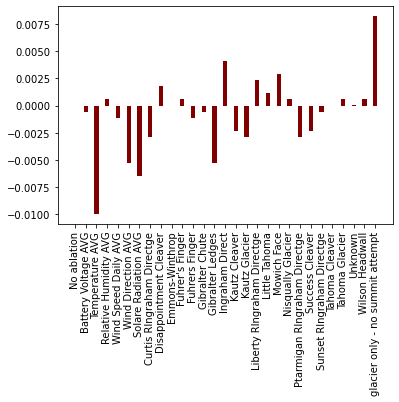

In [33]:
from matplotlib import pyplot as plt

plt.bar(accuracy_drop_log.keys(), accuracy_drop_log.values(), color="maroon", width = 0.4)
plt.xticks(rotation="vertical")

In [34]:
def criteria(l):
    return l[1]

sorted_accs =  sorted(accuracy_drop_log.items(),key=criteria, reverse=True)

print (f"Features are ranked from best to worst (based on how removing them impacts the accuracy of {best_model_name})")
print (f"**************************************")

i=1
for entry in sorted_accs:
    feature_name = entry[0]
    acc_drop = entry[1]
    
    # We do not want to print "No ablation"
    if feature_name != "No ablation":
        print (f"Feature {i}.{feature_name}, drop in acc {acc_drop}")
        i=i+1

Features are ranked from best to worst (based on how removing them impacts the accuracy of grad_boost)
**************************************
Feature 1.glacier only - no summit attempt, drop in acc 0.008228414172686604
Feature 2.Ingraham Direct, drop in acc 0.0041279669762641635
Feature 3.Mowich Face, drop in acc 0.002920536635706905
Feature 4.Liberty RIngraham Directge, drop in acc 0.00235638114895087
Feature 5.Disappointment Cleaver, drop in acc 0.0017647058823528905
Feature 6.Little Tahoma, drop in acc 0.0011833505331957372
Feature 7.Fuhrer's Finger, drop in acc 0.0005951152390781811
Feature 8.Relative Humidity AVG, drop in acc 0.0005951152390780701
Feature 9.Nisqually Glacier, drop in acc 0.0005882352941176672
Feature 10.Tahoma Glacier, drop in acc 0.0005882352941176672
Feature 11.Wilson Headwall, drop in acc 0.0005882352941176672
Feature 12.Unknown, drop in acc 3.4399724802014475e-06
Feature 13.Tahoma Cleaver, drop in acc -3.4399724802014475e-06
Feature 14.Emmons-Winthrop, drop in

It seems like glacier only - no summit attempt is an important feature but its only because there is no attempt at succeeding when one has that route. Every single row that has glacier only - no summit attempt will obviously lead to an output of 0 for no hike. I wonder what the accuracy of the model would look like if we just removed all of the route features. 

## Trying to do everything without the route features

In [36]:
mtrainier_features_df.head()

,Route,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,Disappointment Cleaver,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,Disappointment Cleaver,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,Disappointment Cleaver,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,Little Tahoma,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,Disappointment Cleaver,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292


In [37]:
mtrainier_features_df.pop('Route')

0       Disappointment Cleaver
1       Disappointment Cleaver
2       Disappointment Cleaver
3                Little Tahoma
4       Disappointment Cleaver
                 ...          
1890    Disappointment Cleaver
1891    Disappointment Cleaver
1892    Disappointment Cleaver
1893    Disappointment Cleaver
1894    Disappointment Cleaver
Name: Route, Length: 1895, dtype: object

In [38]:
mtrainier_features_df.head()

,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,13.643750,26.321667,19.715000,27.839583,68.004167,88.496250
1,13.749583,31.300000,21.690708,2.245833,117.549667,93.660417
2,13.461250,46.447917,27.211250,17.163625,259.121375,138.387000
3,13.532083,40.979583,28.335708,19.591167,279.779167,176.382667
4,13.216250,38.260417,74.329167,65.138333,264.687500,27.791292


In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
all_columns = mtrainier_features_df.columns

mtrainier_features_df[all_columns] = scaler.fit_transform(mtrainier_features_df[all_columns])
mtrainier_features_df.head()

,Battery Voltage AVG,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
0,2.003522,-1.580891,-1.269311,1.895222,-0.958813,-1.567664
1,3.506158,-1.033951,-1.180109,-0.902775,-0.414849,-1.520897
2,-0.587638,0.630261,-0.930861,0.728090,1.139477,-1.115850
3,0.418063,0.029488,-0.880092,0.993477,1.366280,-0.771758
4,-4.066182,-0.269251,1.196481,5.972851,1.200588,-2.117412


In [41]:
best_validation_accuracy = 0
best_model_name = ""
best_model = None

# Iterate over all models
for model_name in all_models.keys():
    
    print (f"Evaluating {model_name} ...")
    model = all_models[model_name]
    
    # Let's store training and validation accuracies for all folds
    train_acc_for_all_folds = []
    valid_acc_for_all_folds = []
    
    #Iterate over all folds
    for i, fold in enumerate(folds_data):
        x_train, y_train, x_valid, y_valid = fold

        # Train the model
        _ = model.fit(x_train,y_train.flatten())

        # Evluate model on training data
        y_pred_train = model.predict(x_train)
        
        # Evaluate the model on validation data
        y_pred_valid = model.predict(x_valid)
        
        # Compute training accuracy
        train_acc = accuracy_score(y_pred_train , y_train.flatten())
        
        # Store training accuracy for each folds
        train_acc_for_all_folds.append(train_acc)
        
        # Compute validation accuracy
        valid_acc = accuracy_score(y_pred_valid , y_valid.flatten())

        # Store validation accuracy for each folds
        valid_acc_for_all_folds.append(valid_acc)
    
    #average training accuracy across k folds
    avg_training_acc = sum(train_acc_for_all_folds)/k
    
    print (f"Average training accuracy for model {model_name} = {avg_training_acc}")
    
    #average validation accuracy across k folds
    avg_validation_acc = sum(valid_acc_for_all_folds)/k
    
    print (f"Average validation accuracy for model {model_name} = {avg_validation_acc}")
    
    # Select best model based on average validation accuracy
    if avg_validation_acc > best_validation_accuracy:
        best_validation_accuracy = avg_validation_acc
        best_model_name = model_name
        best_model = model
    print (f"-----------------------------------")

print (f"Best model for the task is {best_model_name} which offers the validation accuracy of {best_validation_accuracy}")

Evaluating lr ...
Average training accuracy for model lr = 0.6205925196098001
Average validation accuracy for model lr = 0.616391468868249
-----------------------------------
Evaluating svm ...
Average training accuracy for model svm = 0.6180512509077628
Average validation accuracy for model svm = 0.618169934640523
-----------------------------------
Evaluating decision_tree ...
Average training accuracy for model decision_tree = 0.6926691836292674
Average validation accuracy for model decision_tree = 0.6065049879600963
-----------------------------------
Evaluating random_forest ...
Average training accuracy for model random_forest = 0.6926691836292674
Average validation accuracy for model random_forest = 0.6164740282077743
-----------------------------------
Evaluating grad_boost ...
Average training accuracy for model grad_boost = 0.6869995625751161
Average validation accuracy for model grad_boost = 0.622328861369109
-----------------------------------
Evaluating voting ...
Average 